In [1]:
# --- 기본 라이브러리 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# --- Scikit-learn ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Activation, add, Dropout, GRU, MultiHeadAttention, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## 데이터 불러오기

In [2]:
# 1. 컬럼 이름 정의 (총 24개)
column_names = [
    'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
    'chest_ecg_1', 'chest_ecg_2',
    'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'arm_acc_x', 'arm_acc_y', 'arm_acc_z',
    'arm_gyro_x', 'arm_gyro_y', 'arm_gyro_z',
    'arm_mag_x', 'arm_mag_y', 'arm_mag_z',
    'activity_label'
]

In [3]:
# 2. 여러 파일을 읽어와 하나의 DataFrame으로 통합
# 개별 DataFrame을 저장할 리스트를 초기화합니다.
dfs_list = []

In [4]:
# 10명의 피실험자 데이터 파일을 반복문으로 처리합니다.
num_subjects = 10
for i in range(1, num_subjects + 1):
    # 파일 이름 생성
    filename = f'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject{i}.log'

    try:
        # 파일을 pandas DataFrame으로 로드
        # 데이터가 공백으로 구분되어 있고(sep='\s+'), 헤더가 없으므로(header=None) 옵션을 지정합니다.
        temp_df = pd.read_csv(
            filename,
            sep=r'\s+',
            header=None,
            names=column_names # 미리 정의한 컬럼 이름을 할당합니다.
        )

        # 'subject' 컬럼을 추가하여 피실험자를 구분합니다.
        temp_df['subject'] = i

        # 처리된 DataFrame을 리스트에 추가합니다.
        dfs_list.append(temp_df)

        print(f"'{filename}' 파일을 성공적으로 로드했습니다. (데이터 수: {len(temp_df)})")

    except FileNotFoundError:
        print(f"[경고] '{filename}' 파일을 찾을 수 없습니다. 이 파일을 건너뜹니다.")

'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject1.log' 파일을 성공적으로 로드했습니다. (데이터 수: 161280)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject2.log' 파일을 성공적으로 로드했습니다. (데이터 수: 130561)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject3.log' 파일을 성공적으로 로드했습니다. (데이터 수: 122112)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject4.log' 파일을 성공적으로 로드했습니다. (데이터 수: 116736)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject5.log' 파일을 성공적으로 로드했습니다. (데이터 수: 119808)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth_subject6.log' 파일을 성공적으로 로드했습니다. (데이터 수: 98304)
'/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week04 (Mhealth dataset)/mHealth

In [5]:
# 3. 모든 DataFrame을 하나로 통합
# 리스트에 저장된 모든 DataFrame을 pd.concat을 사용하여 수직으로 결합합니다.
# ignore_index=True 옵션은 기존 인덱스를 무시하고 새로운 연속적인 인덱스를 생성합니다.
if dfs_list:
    df = pd.concat(dfs_list, ignore_index=True)

    # 4. 최종 결과 확인
    print("\n" + "="*50)
    print("      데이터 통합 및 전처리 완료")
    print("="*50)

    # 통합된 DataFrame의 기본 정보 출력
    print("\n[통합된 DataFrame 정보 (.info())]")
    df.info()

    # 통합된 DataFrame의 상위 5개 행 출력
    print("\n\n[통합된 DataFrame 상위 5개 행 (.head())]")
    print(df.head())

else:
    print("\n[오류] 처리할 데이터 파일이 하나도 없습니다. 파일 경로를 확인해주세요.")


      데이터 통합 및 전처리 완료

[통합된 DataFrame 정보 (.info())]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 25 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   chest_acc_x     1215745 non-null  float64
 1   chest_acc_y     1215745 non-null  float64
 2   chest_acc_z     1215745 non-null  float64
 3   chest_ecg_1     1215745 non-null  float64
 4   chest_ecg_2     1215745 non-null  float64
 5   ankle_acc_x     1215745 non-null  float64
 6   ankle_acc_y     1215745 non-null  float64
 7   ankle_acc_z     1215745 non-null  float64
 8   ankle_gyro_x    1215745 non-null  float64
 9   ankle_gyro_y    1215745 non-null  float64
 10  ankle_gyro_z    1215745 non-null  float64
 11  ankle_mag_x     1215745 non-null  float64
 12  ankle_mag_y     1215745 non-null  float64
 13  ankle_mag_z     1215745 non-null  float64
 14  arm_acc_x       1215745 non-null  float64
 15  arm_acc_y       1215745 non-nu

## 데이터 탐색 및 전처리

In [6]:
# 1. 기본 통계 분석
# describe()는 수치형 데이터에 대한 기술 통계량을 보여줍니다.
# 'activity_label'과 'subject'는 범주형 특성이므로 제외하고 통계량을 확인합니다.
print(df.drop(['activity_label', 'subject'], axis=1).describe())

        chest_acc_x   chest_acc_y   chest_acc_z   chest_ecg_1   chest_ecg_2  \
count  1.215745e+06  1.215745e+06  1.215745e+06  1.215745e+06  1.215745e+06   
mean  -8.522361e+00 -2.140013e-01 -1.055950e+00 -5.122403e-03 -4.506434e-03   
std    4.075293e+00  2.138954e+00  3.574163e+00  7.465971e-01  7.270395e-01   
min   -2.243800e+01 -2.018800e+01 -1.840100e+01 -8.619600e+00 -8.619600e+00   
25%   -9.804000e+00 -1.272900e+00 -2.867300e+00 -2.344300e-01 -1.883800e-01   
50%   -9.311400e+00 -3.538100e-01 -8.702000e-01 -7.116700e-02 -4.186300e-02   
75%   -7.637100e+00  7.097800e-01  7.259100e-01  1.590800e-01  1.507100e-01   
max    1.909400e+01  2.092700e+01  2.619600e+01  8.514900e+00  8.519100e+00   

        ankle_acc_x   ankle_acc_y   ankle_acc_z  ankle_gyro_x  ankle_gyro_y  \
count  1.215745e+06  1.215745e+06  1.215745e+06  1.215745e+06  1.215745e+06   
mean   1.494200e+00 -9.692878e+00 -9.548056e-01 -1.598951e-03 -6.166318e-01   
std    3.826485e+00  4.171303e+00  5.461803e+00  4.

In [7]:
# 결측치(Missing Values) 확인
print(df.isnull().sum())

chest_acc_x       0
chest_acc_y       0
chest_acc_z       0
chest_ecg_1       0
chest_ecg_2       0
ankle_acc_x       0
ankle_acc_y       0
ankle_acc_z       0
ankle_gyro_x      0
ankle_gyro_y      0
ankle_gyro_z      0
ankle_mag_x       0
ankle_mag_y       0
ankle_mag_z       0
arm_acc_x         0
arm_acc_y         0
arm_acc_z         0
arm_gyro_x        0
arm_gyro_y        0
arm_gyro_z        0
arm_mag_x         0
arm_mag_y         0
arm_mag_z         0
activity_label    0
subject           0
dtype: int64


In [8]:
# 2. 레이블 분포 확인 및 시각화
print("Distribution of Activity Labels:")
label_counts = df['activity_label'].value_counts().sort_index()
print(label_counts)

Distribution of Activity Labels:
activity_label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: int64


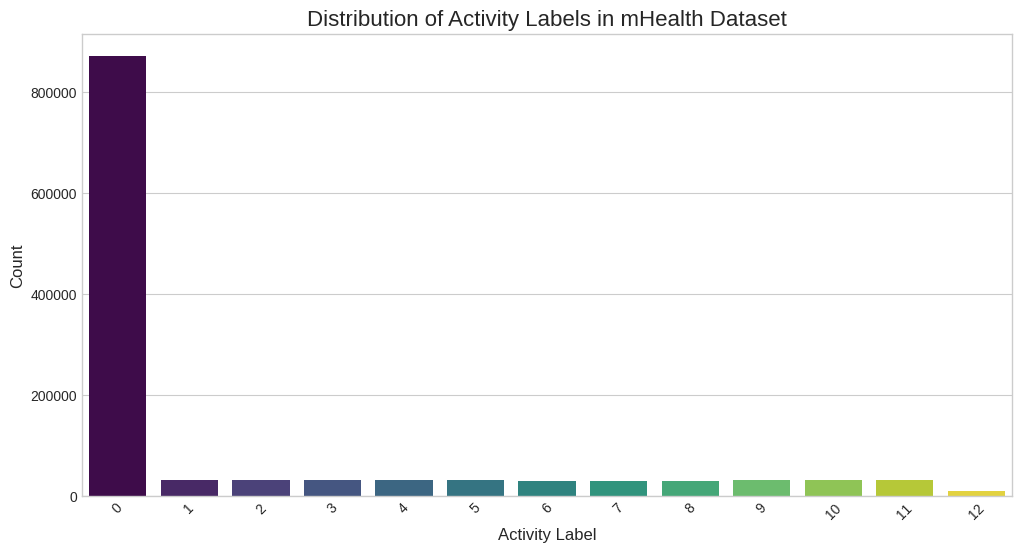

In [9]:
# Seaborn을 사용한 카운트 플롯 시각화
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.countplot(x='activity_label', data=df, hue='activity_label', palette='viridis', legend=False)
plt.title('Distribution of Activity Labels in mHealth Dataset', fontsize=16)
plt.xlabel('Activity Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [10]:
# 'null class' (레이블 0) 데이터 제거
# 레이블 0은 특정 활동이 아닌, 활동 사이의 전환 또는 의미 없는 구간을 나타냅니다.
# 모델 학습 시에는 일반적으로 이를 제외하여 각 활동을 명확히 구분하도록 합니다.
print(f"Original data shape: {df.shape}")
df = df[df['activity_label'] != 0].copy()
print(f"Data shape after removing 'null class' (label 0): {df.shape}")

Original data shape: (1215745, 25)
Data shape after removing 'null class' (label 0): (343195, 25)


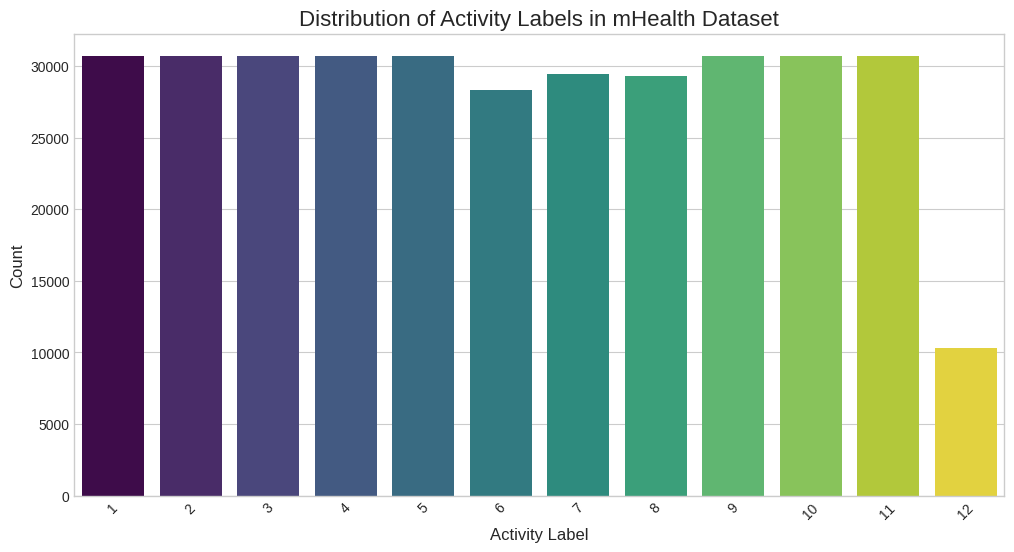

In [11]:
# Seaborn을 사용한 카운트 플롯 시각화
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.countplot(x='activity_label', data=df, hue='activity_label', palette='viridis', legend=False)
plt.title('Distribution of Activity Labels in mHealth Dataset', fontsize=16)
plt.xlabel('Activity Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 데이터 정규화

In [12]:
# StandardScaler를 사용하여 데이터를 표준화합니다 (평균 0, 분산 1).
# subject와 activity_label은 피처가 아니므로 제외합니다.
feature_columns = df.columns.drop(['activity_label', 'subject'])
scaler = StandardScaler()

In [13]:
# 피처 데이터에 대해 정규화를 적용합니다.
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [14]:
print("데이터 정규화 완료. 정규화된 데이터 상위 5개 확인:")
print(df.head())

데이터 정규화 완료. 정규화된 데이터 상위 5개 확인:
      chest_acc_x  chest_acc_y  chest_acc_z  chest_ecg_1  chest_ecg_2  \
6656    -0.402237     0.249278     0.463206     0.005629    -0.029663   
6657    -0.401272     0.149935     0.361900    -0.034285    -0.019902   
6658    -0.416635     0.091640     0.376976     0.025586     0.028905   
6659    -0.395590     0.113398     0.396427     0.210185     0.160678   
6660    -0.402815     0.127633     0.399487     0.105413     0.063070   

      ankle_acc_x  ankle_acc_y  ankle_acc_z  ankle_gyro_x  ankle_gyro_y  ...  \
6656     0.200304    -0.075035     0.167061     -0.677291     -0.780659  ...   
6657     0.144872    -0.090207     0.170926     -0.677291     -0.780659  ...   
6658     0.137943    -0.103380     0.183256     -0.657069     -0.733180  ...   
6659     0.135404    -0.103495     0.175169     -0.657069     -0.733180  ...   
6660     0.123089    -0.092130     0.170708     -0.657069     -0.733180  ...   

      arm_acc_y  arm_acc_z  arm_gyro_x  arm_gyro_

## 슬라이딩 윈도우를 이용한 시퀀스 데이터 생성

In [15]:
# 시계열 데이터를 딥러닝 모델 입력 형식에 맞게 변환하는 함수
def create_sequences(data, labels, time_steps, step):
    """
    Args:
        data (pd.DataFrame): 전체 피처 데이터 (정규화 완료)
        labels (pd.Series): 전체 레이블 데이터
        time_steps (int): 하나의 시퀀스를 구성하는 시간 길이 (윈도우 크기)
        step (int): 윈도우를 움직이는 간격 (오버랩 제어)
    Returns:
        np.array: 시퀀스 피처 데이터 (X)
        np.array: 시퀀스 레이블 데이터 (y)
    """
    X_seq, y_seq = [], []

    for i in range(0, len(data) - time_steps, step):
        # 해당 윈도우의 피처 데이터와 레이블 데이터를 추출
        window_features = data.iloc[i: i + time_steps].values
        window_labels = labels.iloc[i: i + time_steps].values

        # 윈도우 내에서 가장 빈도가 높은 레이블을 해당 윈도우의 대표 레이블로 설정
        # (예: 윈도우 내에 여러 활동이 섞여 있을 경우 다수결로 결정)
        label = stats.mode(window_labels, keepdims=True)[0][0]

        X_seq.append(window_features)
        y_seq.append(label)

    return np.array(X_seq), np.array(y_seq)

In [16]:
# 하이퍼파라미터 설정
# mHealth 데이터셋의 샘플링 주파수는 50Hz이므로, time_steps=100은 2초 분량의 데이터에 해당합니다.
TIME_STEPS = 100  # 윈도우 크기 (2초)
STEP = 50         # 50% 오버랩

In [17]:
# 피처와 레이블, 그룹(subject) 데이터를 분리
features = df[feature_columns]
labels = df['activity_label']
subjects = df['subject']

In [18]:
# 시퀀스 데이터 생성
# 참고: 레이블은 1부터 시작하므로, 나중에 모델 학습 시 0부터 시작하도록 1을 빼줍니다.
X, y = create_sequences(features, labels, TIME_STEPS, STEP)
y = y - 1 # 레이블을 0-11 범위로 조정

In [19]:
# GroupKFold에 사용될 그룹 정보도 시퀀스에 맞게 생성
# 각 시퀀스가 어떤 subject로부터 왔는지 기록
groups = []
for i in range(0, len(subjects) - TIME_STEPS, STEP):
    # 각 윈도우는 시작점의 subject ID를 대표로 가짐
    groups.append(subjects.iloc[i])
groups = np.array(groups)

In [20]:
print(f"시퀀스 데이터 생성 완료.")
print(f"X shape: {X.shape}") # (생성된 시퀀스 수, 윈도우 크기, 피처 수)
print(f"y shape: {y.shape}") # (생성된 시퀀스 수,)
print(f"groups shape: {groups.shape}") # (생성된 시퀀스 수,)

시퀀스 데이터 생성 완료.
X shape: (6862, 100, 23)
y shape: (6862,)
groups shape: (6862,)


## GroupKFold를 이용한 교차 검증 데이터셋 분할 설정

In [21]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

In [22]:
# gkf.split()은 데이터를 나누는 인덱스를 생성합니다.
# 이 인덱스를 사용하여 실제 모델 학습 루프에서 데이터를 분할하게 됩니다.
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    # 검증 데이터에 포함된 subject 확인
    val_subjects = np.unique(groups[val_idx])

    print(f"--- Fold {fold+1} ---")
    print(f"  Train: index={train_idx.shape}, groups={np.unique(groups[train_idx])}")
    print(f"  Validation: index={val_idx.shape}, groups={val_subjects}")

--- Fold 1 ---
  Train: index=(5507,), groups=[ 1  3  4  5  7  8  9 10]
  Validation: index=(1355,), groups=[2 6]
--- Fold 2 ---
  Train: index=(5484,), groups=[1 2 3 5 6 7 8 9]
  Validation: index=(1378,), groups=[ 4 10]
--- Fold 3 ---
  Train: index=(5488,), groups=[ 1  2  4  5  6  7  9 10]
  Validation: index=(1374,), groups=[3 8]
--- Fold 4 ---
  Train: index=(5479,), groups=[ 2  3  4  6  7  8  9 10]
  Validation: index=(1383,), groups=[1 5]
--- Fold 5 ---
  Train: index=(5490,), groups=[ 1  2  3  4  5  6  8 10]
  Validation: index=(1372,), groups=[7 9]


## 모델 정의

In [23]:
# --- 하이퍼파라라미터 및 설정 ---
EPOCHS = 100
BATCH_SIZE = 64
N_CLASSES = 12  # 12개 활동 (1~12)
VERBOSE = 0

In [24]:
# --- 레이블 원-핫 인코딩 ---
# Keras의 categorical_crossentropy 손실 함수를 사용하기 위해
# 정수 레이블(0~11)을 원-핫 벡터로 변환합니다.
# 예: 2 -> [0, 0, 1, 0, ..., 0]
y_categorical = to_categorical(y, num_classes=N_CLASSES)

In [36]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    # Shortcut 경로
    shortcut = inputs

    # 메인 경로
    x = Conv1D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut 연결: 입력과 출력의 채널 수가 다를 경우 1x1 Conv로 차원 맞춤
    if strides > 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [37]:
def build_final_hybrid_model(input_shape, n_classes):
    """
    ResNet + (GAP+GRU+MHA) 모델에 안정화된 학습률과 최적 파라미터를 적용.
    """
    # KerasTuner 결과와 안정성을 고려한 최종 하이퍼파라미터
    gru_dropout = 0.1
    dense_units = 256
    dense_dropout = 0.3
    stable_learning_rate = 0.001  # <<< 수정: 학습률을 0.01에서 0.001로 안정화

    d_model = 128
    num_heads = 4

    input_layer = Input(shape=input_shape)

    # --- 1. ResNet 특징 추출부  ---
    x = Conv1D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, d_model, strides=2)
    resnet_features = resnet_block(x, d_model)

    # --- 2. 병렬 브랜치 (3-Way) ---
    gap_output = GlobalAveragePooling1D()(resnet_features)
    gru_output = GRU(d_model, dropout=gru_dropout)(resnet_features)
    mha_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(resnet_features, resnet_features)
    mha_output = GlobalAveragePooling1D()(mha_output)

    # --- 3. 특징 결합 ---
    combined_features = concatenate([gap_output, gru_output, mha_output])

    # --- 4. 분류기 (최적 하이퍼파라미터 사용) ---
    x = Dense(units=dense_units, activation='relu')(combined_features)
    x = Dropout(rate=dense_dropout)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=stable_learning_rate),
                  metrics=['accuracy'])
    return model

## 함수 정의

In [27]:
def run_cross_validation(model_builder_func, model_name, X_data, y_data_cat, groups_data, gkf_splitter, epochs, batch_size):
    """
    교차 검증을 수행하고 평가 지표를 반환하는 통합 함수.

    Args:
        model_builder_func (function): 모델 생성 함수 (e.g., build_cnn_model)
        model_name (str): 모델 이름 (e.g., "CNN")
        X_data, y_data_cat, groups_data: 전체 데이터셋
        gkf_splitter: GroupKFold 분할기
        epochs, batch_size: 학습 하이퍼파라미터

    Returns:
        dict: 모든 폴드의 학습 history와 평가 점수를 담은 딕셔너리
    """
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
    history_list, y_true_all, y_pred_all = [], [], []

    print(f"\n{'='*25} Running Cross-Validation for {model_name} {'='*25}")

    for fold, (train_idx, val_idx) in enumerate(gkf_splitter.split(X_data, None, groups_data)):
        print(f"\n----- {model_name} Fold {fold+1}/{gkf_splitter.get_n_splits()} -----")

        # 데이터 분할
        X_train, y_train_cat = X_data[train_idx], y_data_cat[train_idx]
        X_val, y_val_cat = X_data[val_idx], y_data_cat[val_idx]

        print(f"Validation Subjects: {np.unique(groups_data[val_idx])}")

        # 모델 생성
        input_shape = (X_train.shape[1], X_train.shape[2])
        n_classes = y_train_cat.shape[1]
        model = model_builder_func(input_shape, n_classes)

        if fold == 0: model.summary()

        # 검증 손실이 5 에포크 동안 개선되지 않으면 학습을 조기 종료합니다. (과적합 방지)
        # restore_best_weights=True 옵션은 가장 성능이 좋았던 시점의 가중치를 모델에 복원합니다.
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

        # 검증 손실이 3 에포크 동안 정체되면 학습률을 0.5배 감소시킵니다. (미세 조정)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, mode='min')

        # 모델 학습
        history = model.fit(X_train, y_train_cat,
                            batch_size=batch_size,
                            epochs=epochs, # EarlyStopping이 최적의 에포크에서 중단시키므로 넉넉하게 설정
                            validation_data=(X_val, y_val_cat),
                            verbose=VERBOSE,
                            callbacks=[early_stopping, reduce_lr])
        history_list.append(history)

        # 모델 평가
        y_pred = np.argmax(model.predict(X_val), axis=1)
        y_val_true = np.argmax(y_val_cat, axis=1)

        y_true_all.extend(y_val_true)
        y_pred_all.extend(y_pred)

        # 계산된 평가 지표
        current_accuracy = accuracy_score(y_val_true, y_pred)
        current_precision = precision_score(y_val_true, y_pred, average='macro', zero_division=0)
        current_recall = recall_score(y_val_true, y_pred, average='macro', zero_division=0)
        current_f1 = f1_score(y_val_true, y_pred, average='macro', zero_division=0)

        # 리스트에 추가
        accuracy_list.append(current_accuracy)
        precision_list.append(current_precision)
        recall_list.append(current_recall)
        f1_list.append(current_f1)


        print(f"  -> Accuracy: {current_accuracy:.4f}, Precision: {current_precision:.4f}, Recall: {current_recall:.4f}, F1-Score: {current_f1:.4f}")

    results = {
        'accuracy': accuracy_list, 'precision': precision_list, 'recall': recall_list, 'f1': f1_list,
        'history': history_list, 'y_true': y_true_all, 'y_pred': y_pred_all
    }
    return results

In [28]:
def plot_loss_curves(histories, model_name):
    """교차 검증 폴드들의 평균 학습/검증 손실 곡선을 시각화합니다."""

    # 각 폴드의 loss와 val_loss를 추출
    train_losses = pd.DataFrame([h.history['loss'] for h in histories]).transpose()
    val_losses = pd.DataFrame([h.history['val_loss'] for h in histories]).transpose()

    # 평균 및 표준편차 계산
    mean_train_loss = train_losses.mean(axis=1)
    std_train_loss = train_losses.std(axis=1)
    mean_val_loss = val_losses.mean(axis=1)
    std_val_loss = val_losses.std(axis=1)

    epochs_range = range(1, len(mean_train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # 평균 곡선
    plt.plot(epochs_range, mean_train_loss, 'o-', color='royalblue', label='Average Training Loss')
    plt.plot(epochs_range, mean_val_loss, 'o-', color='orangered', label='Average Validation Loss')

    # 표준편차 음영 영역
    plt.fill_between(epochs_range, mean_train_loss - std_train_loss,
                     mean_train_loss + std_train_loss, color='royalblue', alpha=0.2)
    plt.fill_between(epochs_range, mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, color='orangered', alpha=0.2)

    plt.title(f'{model_name} - Average Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """통합 혼동 행렬을 시각화합니다."""
    cm = confusion_matrix(y_true, y_pred)
    # 정규화: 각 행(실제 클래스)의 합이 1이 되도록 하여, 재현율(Recall)을 시각화
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=plt.cm.Blues,
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'{model_name} - Normalized Confusion Matrix (Recall)', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

## 메인

In [38]:
# 모든 모델의 결과를 저장할 딕셔너리
all_model_results = {}

In [39]:
print("\n=== 최종 하이브리드(GAP+GRU+MHA) 모델 교차 검증 실행 ===")
final_hybrid_results = run_cross_validation(
    build_final_hybrid_model,
    "Final-Hybrid-Model",
    X,
    y_categorical,
    groups,
    gkf,
    EPOCHS,
    BATCH_SIZE
)
all_model_results['Final-Hybrid-Model'] = final_hybrid_results


=== 최종 하이브리드(GAP+GRU+MHA) 모델 교차 검증 실행 ===

========================= Running Cross-Validation for Final-Hybrid-Model =========================

----- Final-Hybrid-Model Fold 1/5 -----
Validation Subjects: [2 6]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 50, 64)    │     10,368 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 50, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 25, 64)    │          0 │ activation_45[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 25, 64)    │     12,352 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 64)    │        256 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 25, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 25, 64)    │     12,352 │ activation_46[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 64)    │        256 │ conv1d_52[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 25, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 25, 64)    │          0 │ add_20[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 25, 64)    │     12,352 │ activation_47[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 64)    │        256 │ conv1d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 25, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 25, 64)    │     12,352 │ activation_48[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 64)    │        256 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 25, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_47[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 511,244 (1.95 MB)

 Trainable params: 509,324 (1.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
  -> Accuracy: 0.9085, Precision: 0.9228, Recall: 0.9094, F1-Score: 0.9068

----- Final-Hybrid-Model Fold 2/5 -----
Validation Subjects: [ 4 10]
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
  -> Accuracy: 0.9579, Precision: 0.9646, Recall: 0.9604, F1-Score: 0.9600

----- Final-Hybrid-Model Fold 3/5 -----
Validation Subjects: [3 8]
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
  -> Accuracy: 0.9425, Precision: 0.9591, Recall: 0.9423, F1-Score: 0.9406

----- Final-Hybrid-Model Fold 4/5 -----
Validation Subjects: [1 5]
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
  -> Accuracy: 0.9704, Precision: 0.9728, Recall: 0.9574, F1-Score: 0.9630

----- Final-Hybrid-Model Fold 5/5 -----
Validation Subjects: [7 9]
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
  -> Accuracy: 0.9942, Precision: 0.9946, Recall: 0.9920, F1-Score: 0.9932


## 결과

In [40]:
summary_data = []

In [41]:
ACTIVITY_LABELS = [
    '1: Standing still', '2: Sitting and relaxing', '3: Lying down', '4: Walking',
    '5: Climbing stairs', '6: Waist bends forward', '7: Frontal elevation of arms', '8: Knees bending',
    '9: Cycling', '10: Jogging ', '11: Running', '12: Jump front & back'
]


--- Classification Report for Final-Hybrid-Model ---
                              precision    recall  f1-score   support

           1: Standing still       0.98      0.99      0.99       612
     2: Sitting and relaxing       0.98      0.89      0.94       615
               3: Lying down       0.99      1.00      0.99       615
                  4: Walking       0.97      1.00      0.98       613
          5: Climbing stairs       0.90      0.98      0.94       614
      6: Waist bends forward       0.99      0.92      0.96       569
7: Frontal elevation of arms       0.98      0.99      0.99       588
            8: Knees bending       0.95      0.98      0.97       587
                  9: Cycling       1.00      0.99      0.99       614
                10: Jogging        0.89      0.86      0.87       614
                 11: Running       0.88      0.91      0.89       615
       12: Jump front & back       0.99      0.91      0.95       206

                    accuracy      

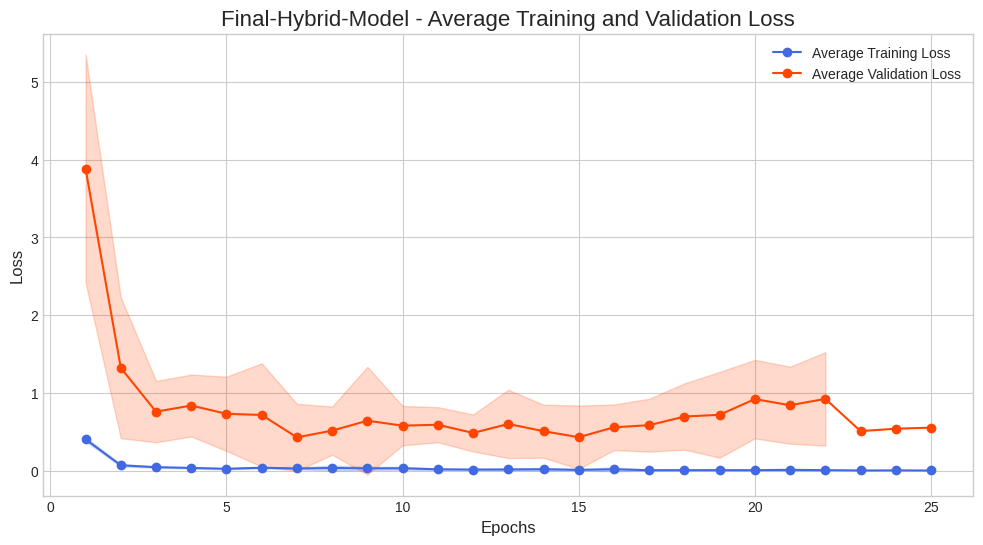

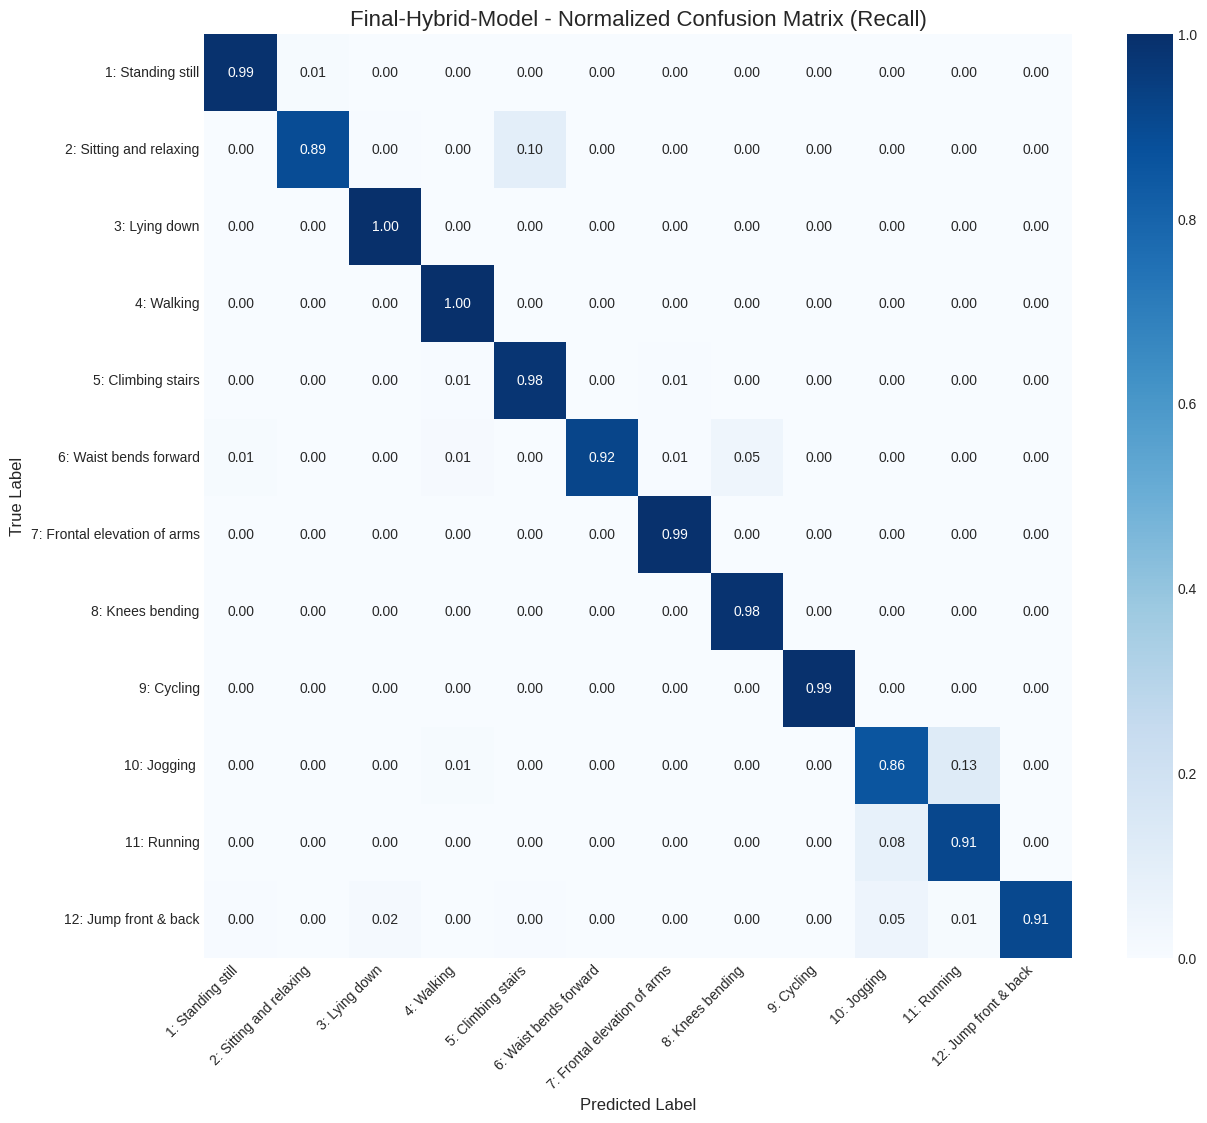

In [42]:
for model_name, results in all_model_results.items():
    # 성능 요약 출력
    y_true_all = results['y_true']
    y_pred_all = results['y_pred']

    print(f"\n--- Classification Report for {model_name} ---")
    print(classification_report(y_true_all, y_pred_all, target_names=ACTIVITY_LABELS))

    # 시각화 호출
    plot_loss_curves(results['history'], model_name)
    plot_confusion_matrix(results['y_true'], results['y_pred'], ACTIVITY_LABELS, model_name)

    summary_data.append({
        'Model': model_name,
        'Accuracy': np.mean(results['accuracy']),
        'F1-Score': np.mean(results['f1']),
        'Precision': np.mean(results['precision']),
        'Recall': np.mean(results['recall'])
    })

In [43]:
# 최종 성능 비교 테이블
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

             Model  Accuracy  F1-Score  Precision   Recall
Final-Hybrid-Model  0.954685  0.952732   0.962771 0.952289
